In [4]:
import sqlite3, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing

In [ ]:
db_path = '/content/drive/MyDrive/statlearning/KB/stock_insights.db'
out_path = '/content/drive/MyDrive/statlearning/KB/sentiment_dataset_raw.jsonl'

with sqlite3.connect(db_path) as conn, open(out_path, 'w', encoding='utf-8') as f:
    cur = conn.cursor()
    query = """
        SELECT s.sentence_id, s.sentence_text, e.entity_text, s.sentiment_score, s.sentiment_label
        FROM   Sentences AS s
        JOIN   Entities  AS e ON s.sentence_id = e.sentence_id
        WHERE  e.entity_type IN ('STOCK','COMPANY')
          AND  e.confidence  = 'high'
          AND  s.sentiment_label IS NOT NULL
        ORDER BY s.sentence_id
    """
    for row in cur.execute(query):
        data = {
            "sentence_id": row[0],
            "sentence_text": row[1],
            "entity_text": row[2],
            "sentiment_score": row[3],
            "sentiment_label": row[4]
        }
        f.write(json.dumps(data, ensure_ascii=False) + '\n')

In [ ]:
with open('/content/drive/MyDrive/statlearning/KB/sentiment_dataset_raw.jsonl', 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

data

[{'sentence_id': 1,
  'sentence_text': 'Con gái bầu Đức gom bất thành 4 triệu cp HAG vì không xoay được tiền.',
  'entity_text': 'HAG',
  'sentiment_score': -2.0,
  'sentiment_label': 'negative'},
 {'sentence_id': 1,
  'sentence_text': 'Con gái bầu Đức gom bất thành 4 triệu cp HAG vì không xoay được tiền.',
  'entity_text': 'cp HAG',
  'sentiment_score': -2.0,
  'sentiment_label': 'negative'},
 {'sentence_id': 2,
  'sentence_text': 'Bà Đoàn Hoàng Anh, con gái ông Đoàn Nguyên Đức, không mua được bất kỳ cổ phiếu nào trong số 4 triệu cổ phiếu HAG đăng ký, do không thu xếp được tài chính cá nhân.',
  'entity_text': 'HAG',
  'sentiment_score': -2.8,
  'sentiment_label': 'negative'},
 {'sentence_id': 2,
  'sentence_text': 'Bà Đoàn Hoàng Anh, con gái ông Đoàn Nguyên Đức, không mua được bất kỳ cổ phiếu nào trong số 4 triệu cổ phiếu HAG đăng ký, do không thu xếp được tài chính cá nhân.',
  'entity_text': 'cổ phiếu HAG',
  'sentiment_score': -2.8,
  'sentiment_label': 'negative'},
 {'sentence_id

In [ ]:
len(data)

39284

In [ ]:
df = pd.DataFrame(data)

label_counts = df['sentiment_label'].value_counts()
print('Number of sample/sentiment')
print(label_counts)

Number of sample/sentiment
sentiment_label
neutral     14732
positive    13264
negative    11288
Name: count, dtype: int64


/tmp/ipython-input-4139049609.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


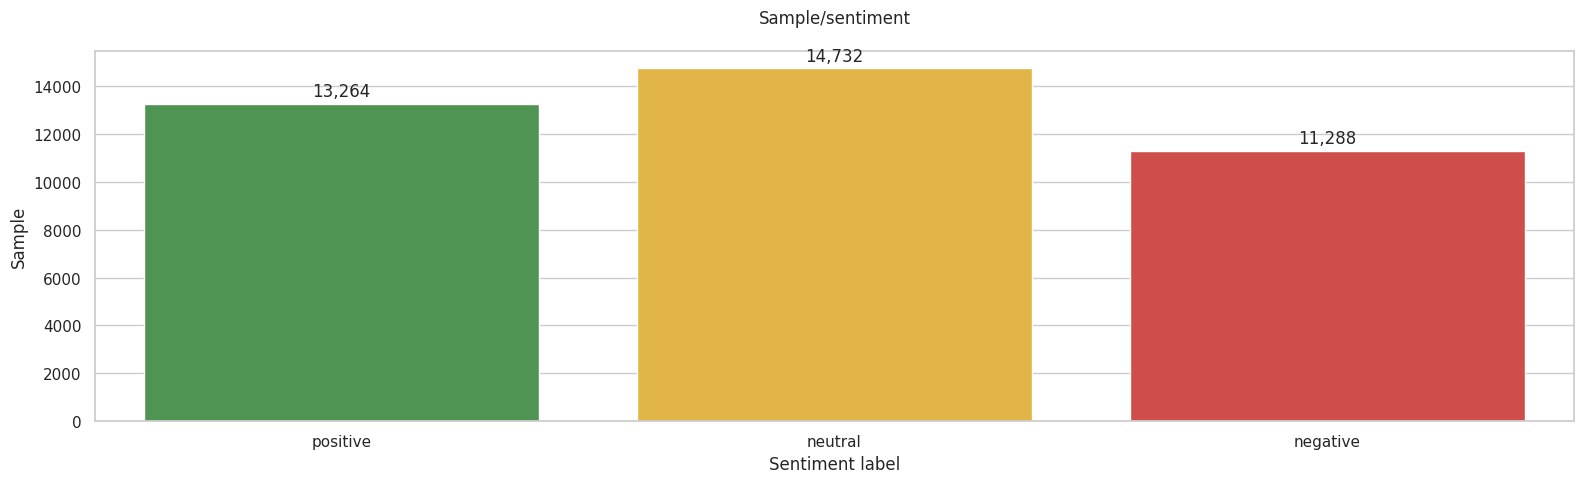

In [ ]:
order = ['positive', 'neutral', 'negative']
label_counts = label_counts.reindex(order)

plt.figure(figsize=(16, 5))
sns.set_theme(plt.grid(True))
ax = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette=['#43a047', '#fbc02d', '#e53935']
)

for i, v in enumerate(label_counts.values):
    ax.text(i, v + max(label_counts.values)*0.01, f'{int(v):,}',
            ha='center', va='bottom')

plt.title('Sample/sentiment', pad=20)
plt.xlabel('Sentiment label')
plt.ylabel('Sample')
plt.tight_layout()
plt.savefig('sentiment_label.svg`', format='svg')
plt.show()

**Relatively Balanced**
==> Thus, we do not have to down sampling.



# Model configuration

## Splitting

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict, load_from_disk
import torch

In [ ]:
full_dataset = Dataset.from_pandas(df)
full_dataset

Dataset({
    features: ['sentence_id', 'sentence_text', 'entity_text', 'sentiment_score', 'sentiment_label'],
    num_rows: 39284
})

In [ ]:
# 8/1/1
train_test_split = full_dataset.train_test_split(test_size=0.2, seed=42)
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)

sentiment_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': test_val_split['train'],
    'test': test_val_split['test']
})

sentiment_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'sentence_text', 'entity_text', 'sentiment_score', 'sentiment_label'],
        num_rows: 31427
    })
    validation: Dataset({
        features: ['sentence_id', 'sentence_text', 'entity_text', 'sentiment_score', 'sentiment_label'],
        num_rows: 3928
    })
    test: Dataset({
        features: ['sentence_id', 'sentence_text', 'entity_text', 'sentiment_score', 'sentiment_label'],
        num_rows: 3929
    })
})

In [ ]:
sentiment_datasets.save_to_disk('/content/drive/MyDrive/statlearning/sentiment_datasets')

Saving the dataset (0/1 shards):   0%|          | 0/31427 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3929 [00:00<?, ? examples/s]

## Tokenize

In [11]:
# login hugginface hub
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [ ]:
def preprocess_and_tokenize(examples):
    formatted_inputs = [
        f"<s> {sentence} </s> {aspect} </s>"
        for sentence, aspect in zip(examples['sentence_text'], examples['entity_text'])
    ]

    model_inputs = tokenizer(formatted_inputs, max_length=256, truncation=True, padding="max_length")

    return model_inputs

In [ ]:
tokenized_datasets = sentiment_datasets.map(preprocess_and_tokenize, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['sentence_text', 'entity_text', 'sentence_id', 'sentiment_score'])
tokenized_datasets

Map:   0%|          | 0/31427 [00:00<?, ? examples/s]

Map:   0%|          | 0/3928 [00:00<?, ? examples/s]

Map:   0%|          | 0/3929 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentiment_label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31427
    })
    validation: Dataset({
        features: ['sentiment_label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3928
    })
    test: Dataset({
        features: ['sentiment_label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3929
    })
})

In [ ]:
tokenized_datasets = tokenized_datasets.rename_column("sentiment_label", "labels")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31427
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3928
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3929
    })
})

In [ ]:
label2id = {'positive': 0, 'neutral': 1, 'negative': 2}

def encode_labels(example):
    example['labels'] = label2id[example['labels']] if isinstance(example['labels'], str) else example['labels']
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)
tokenized_datasets

Map:   0%|          | 0/31427 [00:00<?, ? examples/s]

Map:   0%|          | 0/3928 [00:00<?, ? examples/s]

Map:   0%|          | 0/3929 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31427
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3928
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3929
    })
})

In [ ]:
tokenized_datasets['train'][0]

{'labels': 1,
 'input_ids': [0,
  0,
  1967,
  3959,
  15,
  302,
  1430,
  4072,
  2415,
  8,
  14504,
  119,
  2057,
  22670,
  1384,
  4,
  811,
  4153,
  14504,
  119,
  58,
  227,
  26,
  2927,
  380,
  4072,
  2415,
  2106,
  4698,
  574,
  1626,
  3011,
  8804,
  34,
  8316,
  4777,
  418,
  54,
  66,
  11,
  2927,
  380,
  13,
  159,
  14504,
  119,
  2057,
  22670,
  1384,
  4,
  811,
  4153,
  14504,
  119,
  58,
  227,
  27772,
  5,
  2,
  8316,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

In [ ]:
tokenized_datasets.save_to_disk('/content/drive/MyDrive/statlearning/sentiment_tokenized_datasets')

Saving the dataset (0/1 shards):   0%|          | 0/31427 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3928 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3929 [00:00<?, ? examples/s]

# Finetuning

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00


In [1]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    HfArgumentParser,
    PretrainedConfig,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
    set_seed,
)
from datasets import Dataset, DatasetDict, load_from_disk
import evaluate
import numpy as np

In [2]:
# Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ds = load_from_disk('/content/drive/MyDrive/statlearning/sentiment_tokenized_datasets')
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31427
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3928
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3929
    })
})

In [5]:
from huggingface_hub import notebook_login

notebook_login() #token tương ứng với acc có repo

In [6]:
label2id = {'positive': 0, 'neutral': 1, 'negative': 2}
id2label = {v: k for k, v in label2id.items()}

model_name = 'vinai/phobert-base-v2'
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    label2id=label2id,
    id2label=id2label
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [2]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = ds['train']['labels']
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

In [9]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [10]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    report = classification_report(labels, preds, target_names=['positive', 'neutral', 'negative'], output_dict=True)
    metrics = {
        "accuracy": report["accuracy"],
        "f1_positive": report["positive"]["f1-score"],
        "f1_neutral": report["neutral"]["f1-score"],
        "f1_negative": report["negative"]["f1-score"],
        "macro_f1": report["macro avg"]["f1-score"],
        "macro_precision": report["macro avg"]["precision"],
        "macro_recall": report["macro avg"]["recall"],
    }
    return metrics

In [11]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/statlearning/phobert_sentiment",
    num_train_epochs=5,               # Số lần duyệt hết dữ liệu huấn luyện
    per_device_train_batch_size=16,   # Batch size cho mỗi GPU/CPU
    per_device_eval_batch_size=16,    # Batch size khi đánh giá (16 là đủ rồi)
    learning_rate=2e-5,               # Tốc độ học (LR)
    weight_decay=0.01,                # L2 regularization
    eval_strategy="epoch",            # Đánh giá sau mỗi epoch (hoặc "steps")
    logging_strategy="steps",         # Ghi log mỗi vài bước
    #lr_scheduler_type="linear",
    logging_steps=100,                 # Bao nhiêu bước ghi một lần
    load_best_model_at_end=True,      #cờ để lần sau train tiếp
    push_to_hub = True,               # đẩy lên hugging face
    hub_model_id = "VTKK/phobert-sentiment-analysis",
    save_strategy="epoch",            # Lưu model sau mỗi epoch
    metric_for_best_model="f1",       # Chọn model tốt nhất theo F1-score
    greater_is_better=True,           # F1 càng lớn càng tốt
    seed=42,                          # Đặt seed để tái lập kết quả
    report_to= "none"
)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.push_to_hub(commit_message="Upload phobert-sentiment model")